# Import Packages

Utilizing Anaconda is going to make importing all of these packages managable.

In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cProfile
import pstats
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

dev = ""

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

# Interpolating acceleration columns with average values

Taking data in from a csv, converting to Pandas DataFrame, then normalizing

In [2]:
#replaces Nan values with average values
#df: data frame of data to use
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Load and scale data

In [3]:
##load and scale data
#returns scaled data (X) and labels (Y)
#file_name: string, file with data to be used
#label: string, activity to do
def start_data(file_name, label):
    #read csv into dataframe
    data = pd.read_csv(file_name)
    
    #seperate only acceleration data
    X = data.iloc[:,1:27]
    y = data[[label]]

    #seperate only "on" labels
    X = X[y[label] == 1]
    y = y[y[label] == 1]
    
    #interpolate averages per column
    X = interpolation(X).values
    y = interpolation(y).values
    
    #scale the data
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    return X, y

# Generator Architecture and its Loss

Here we define the generator. In this case, it is a feed forward network consisting of 5 layers. The first 4 layers are accompanied with dropout and a batchnormalization. Also, since these and the middle or "deep" layers, we use a ReLu activation function. 

Dropout and Batch Norm: https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

ReLu: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

We also define the loss function for the generator, in this case Binary Cross Entropy BCE)
BCE: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [4]:
#defines each generator layer
#input and output dimensions needed
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )

#returns n_samples of z_dim (number of dimensions of latent space) noise
def get_noise(n_samples, z_dim):
    #torch.manual_seed(0)
    return 200 * torch.randn(n_samples, z_dim).to(device)

#defines generator class
class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, int(hidden_dim/2)),
            generator_block(int(hidden_dim/2), int(hidden_dim/4)),
            generator_block(int(hidden_dim/4), 30),
            generator_block(30, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

##calculates generator loss
#gen: generator
#disc: discriminator
#criterion: loss function
#batch_size: batch size
#z_dim: number of dimensions in the latent space
def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    disc.eval()
    pred = disc(fake_features)
    disc.train()
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

# Discriminator Architecture and Its Loss

Here we define the discriminator. In this case, it is a feed forward network consisting of 4 layers. The first 4 layers are accompanied with dropout. For these middle layers, we use a slightly different activation, LeakyReLu.

About Leaky ReLu: https://himanshuxd.medium.com/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

We also define the loss function for the discriminator, in this case Binary Cross Entropy (BCE) on both the 

In [5]:
#defines each discriminator layer
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

#defines discriminator class
class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

##calculates discriminator loss
#gen: generator
#disc: discriminator
#real_features: real (not generated) data
#batch_size: batch size
#z_dim: number of dimensions of the latent space
def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    gen.eval()
    fake_features = gen(latent_vectors)
    gen.train()
    pred_fake = disc(fake_features.detach())
    loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
                     
    pred_real = disc(real_features)
    loss_real = criterion(pred_real, torch.ones_like(pred_real))
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

# Visualize Batches

In [6]:
##prints a plot of a generator batch
#gen: generator
#b_size: batch size
#epochs: current epoch (-1)
def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()

##prints a plot of a batch of real data
#features: real data
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()

# Calculate Performance Statistics

In [7]:
##calculates performance statistics for each epoch of training
#gen: generator
#disc: discriminator
#b_size: batch size
#z_dim: number of dimensions of the latent space
##returns accuracy, precision, recall, fpR, and f1 score
def performance_stats(gen, disc, b_size, z_dim, batch = None):
    tp = 0 #true positive
    fp = 0 #false positive
    tn = 0 #true negative
    fn = 0 #false negative

    with torch.no_grad():
        y_hat_fake = torch.Tensor([0])
        y_hat_real = torch.Tensor([0])
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            gen.eval()
            fake_features = gen(latent_vectors)
            gen.train()
            disc.eval()
            y_hat_fake = torch.round(disc(fake_features))
            disc.train()
        else:
            latent_vectors = get_noise(b_size, z_dim)
            gen.eval()
            fake_features = gen(latent_vectors)
            gen.train()
            disc.eval()
            y_hat_fake = torch.round(disc(fake_features))
            y_hat_real = torch.round(disc(batch))
            disc.train()
         
        fpR = torch.mean(y_hat_fake)
        recall = torch.mean(y_hat_real)
        class_acc = ((len(y_hat_fake) - torch.sum(y_hat_fake)) + torch.sum(y_hat_real)) / (2*b_size)
        #print(f'Classification Accuracy: {class_acc:.2f}'
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        return class_acc, recall, fpR
    

# Create Density Curves

In [8]:
#create and plot density curves for mean, x, y, z acceleration
#reals: real data
#fakes: generated data
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.cpu().numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.cpu().numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.cpu().numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.cpu().numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Create fake samples

In [9]:
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    gen.eval()
    fake_features = gen(latent_vectors)
    gen.train()
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

# Calculate Wassertein distance for each dimension

In [10]:
##calculate Waaserstein distances for each dimension
#gen: generator
#z_dim: number of dimensions of the latent space
#feature_dim: number ofd dimensions in the feature space
#sample: sample of data
def all_Wasserstein_dists(gen, z_dim, feature_dim, sample):
    latent_vectors = get_noise(len(sample), z_dim)
    gen.eval()
    fake_features = gen(latent_vectors).cpu().detach().numpy()
    gen.train()
    sample = sample.cpu().detach().numpy()
    return torch.tensor([wasserstein_distance(fake_features[:, k], sample[:, k]) for k in range(feature_dim)])

# Initialize Training Environment 

In [11]:
###initalize parameters that depend on training loop parameters
#X: acceleration data
#y: labels associated with X data (fake or real)
#z_dim: number of dimensions to the latent space
#disc_lr: discriminator learning rate
#gen_lr: generator learning rate
#DISCRIMINATOR: 1 to indicate if discriminator is training
#batch_size: batch size
#disc: initialized discrimiantor

def initialize_params(X, y, z_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc):
    #initialize generator
    gen = Generator(z_dim).to(device)
    #indicate that discriminator is training
    to_train = DISCRIMINATOR
    #create training features
    train_features = torch.tensor(X)
    #create training labels
    train_labels = torch.tensor(y)
    #concatenate to create training data
    train_data = torch.utils.data.TensorDataset(train_features, train_labels)
    #create data loader for training data
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    #initialize generator and discriminator optimizers
    opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
    opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)
    
    return gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen   

# Saving the Model

In [12]:
# Change path and name of the Generator and Discriminator accordingly
def save_model(gen, disc, model_name):
    torch.save(gen.state_dict(), f"saved_models/{model_name}_gen.param")
    torch.save(disc.state_dict(), f"saved_models/{model_name}_disc.param")

# Visualizing Generation Quality

In [13]:
#creates and prints a plot of the generated vs real data
#data: data used
#gen: generator
#z_dim: number of dimensions of the latent space
def visualize_gen(data, gen, z_dim):
    #Number of datum to visualize
    sample_size = len(data)
    reals = data[0:sample_size, :]
    fakes = get_fake_samples(gen, sample_size, z_dim).detach()
    density_curves(reals, fakes)

# Plot Metrics

In [14]:
#plot metrics based on data (csv)
def plot_metrics(data, vanilla = True):
    if vanilla:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    
        plt.figure(figsize = (15, 15))
        subplot(2, 2, 1)
        sns.scatterplot(x = 'Epoch', y = 'FPR', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 2)
        sns.scatterplot(x = 'Epoch', y = 'Recall', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 3)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 4)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        plt.show()
    else:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
        plt.figure(figsize = (15, 8))
        
        subplot(1, 2, 1)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(1, 2, 2)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        plt.show()

# Training Loop

In [15]:
######Training loop to train GAN

#Parameters to specifiy: 
    #X: starting accelerometer data
    #y: starting labels for X data (fake or real)
    
#Set parameters (do not change)
    #criterion: loss function (BCE)
    #dig: number of significant digits for printing (5)
    #feature_dim: Number of dimensions of output from generator (26)
    #GENERATOR: set generator to zero for training
    #DISCRIMINATOR: set discriminator to one for training
    #train_string: starting machine to train (DISC)
    #disc: initalize discriminator
    #rel_epochs: Epochs passed since last switch (constant training) (0)
    #rows: initialization of array to save data of each epoch to CSV file ([])
    #heading: array of column headings for table (["Epoch", "Machine Training", "Discriminator Loss", 
                    #"Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"])
    #table: intialize a table as a pretty table to save epoch data
    #switch_count: number of switches in dynamic training (0)
    
#Set parameters (can change):
    #z_dim: number of dimensions of latent vector (100)
    #gen_lr: generator learning rate (.001)
    #disc_lr: discriminator learning rate (.001) (shoud be equal to gen_lr)
    #batch_size: batch size (75)
    #print_batches: Show model performance per batch (False)
    #n_epochs: number of epochs to train (100)
    #constant_train_flag: (False)
        #Set to true to train based on constant # of epochs per machine 
        #Set to false to train dynamically based on machine performance
    #save_models:
        #Set to true to save loss outputs to .txt, .csv, and model parameters (.param)
        #Set to false to not record any data during training 
        
    #Constant training approach:
        #disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (5)
        #gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #epoch_threshold: Epoch number to change training epoch ratio (50)
        #disc_epochs_change: New number of consecutive epochs to train discriminator after epoch threshold is exceeded (1)
        #gen_epochs_change: New number of consecutive epochs to train generator after epoch threshold is exceeded (50)
    
    #Dynamic training approach:                        
        #static_threshold: Epoch number to change from static ratio to dynamic (18)
        #static_disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (4)
        #static_gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #pull_threshold: Accuracy threshold for switching machine training when the generator is no longer competitive (0.4)
        #push_threshold: Accuracy threshold for switching machine training when the discriminator is no longer competitive (0.6)
        #recall_threshold: threshold for recall to switch machine training when discriminator is training well
        #switch_flag: indicates if we should switch our training machine (False)
        
def training_loop(X, y, criterion = nn.BCELoss(), gan_id = "Demo_GAN", dig = 5, feature_dim = 26, 
                  GENERATOR = 0, DISCRIMINATOR = 1, train_string = "DISC", disc = Discriminator(), z_dim = 100, 
                  gen_lr =  0.001, disc_lr = 0.001, batch_size = 100, constant_train_flag = True, disc_epochs = 5,
                  gen_epochs = 2, epoch_threshold = 1000000, disc_epochs_change = 5, gen_epochs_change = 2, rel_epochs = 0,
                 static_threshold = 14, static_disc_epochs = 5, static_gen_epochs = 2, pull_threshold = 0.2,
                 push_threshold = 0.8, recall_threshold = 0.75, n_epochs = 100, rows = [],
                 heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "Accuracy", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"],
                 table = PrettyTable(), switch_flag = False, switch_count = 0, last_real_features = [], save_models = True):
    
    disc.to(device)
    #returns generator, sets discriminator training, creates training tensor, loads data, and initializes optimizers
    gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen = initialize_params(X, y, z_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc)

    #set pretty table field names
    table.field_names = heading
    
    #Print Visualization of PDF's of Latent vs. Real Distribution
    print("Latent vs. Real Distributions")
    visualize_gen(X, gen, z_dim)
    
    train_type = "Conventional"
    if not constant_train_flag:
        train_type = "Dynamic"
        
    print("Starting Training: " + train_type)
    
    gen_trained = 0
    
    last_D_loss = -1.0
    last_G_loss = -1.0
    
    print("\nTraining Discriminator, Freezing Generator")
    
    for epoch in range(n_epochs):  
        if constant_train_flag:
            if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"
                print("\nTraining Generator, Freezing Discriminator")

            elif to_train == GENERATOR and rel_epochs >= gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nTraining Discriminator, Freezing Generator")

            # Change epoch ratio after intial 'leveling out'
            if epoch == epoch_threshold:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GENERATOR"

                old_ratio = gen_epochs / disc_epochs
                gen_epochs = gen_epochs_change
                disc_epochs = disc_epochs_change
                new_ratio = gen_epochs / disc_epochs
                print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
        else:
            if epoch < static_threshold:
                if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                    rel_epochs = 0
                    to_train = GENERATOR
                    train_string = "GEN"
                    print("\nTraining Generator, Freezing Discriminator")

                elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                    rel_epochs = 0
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                    print("\nTraining Discriminator, Freezing Generator")

            else:
                if not switch_flag:
                    print("\nSwitching to Dynamic Training")
                    print("Pushing Generator, Freezing Generator")
                    switch_flag = True
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                    to_train = GENERATOR
                    train_string = "GEN"
                    print("\nPulling Generator, Freezing Discriminator")
                    switch_count += 1
                elif to_train == GENERATOR and fpR >= push_threshold:
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                    print("\nPushing Generator, Freezing Generator")
                    switch_count += 1
        print(f'Epoch[{epoch + 1}/{n_epochs}] {train_string} ', end ='')
        for batch_idx, (real_features, _) in enumerate(train_loader):
            batch_size = len(real_features)
            #Send batch to GPU
            real_features = real_features.float().to(device)
            
            if to_train == DISCRIMINATOR:
                ### Training Discriminator
                #visualize_real_batch(real_features.float())
                opt_disc.zero_grad()
                disc_loss = get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim)
                disc_loss.backward(retain_graph = True)
                opt_disc.step()
                last_D_loss = disc_loss.item()
                
                if last_G_loss == -1.0:
                    last_G_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
            
            else:
                ### Training Generator
                gen_trained += 1
                
                opt_gen.zero_grad()
                gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
                gen_loss.backward()
                opt_gen.step()
                last_G_loss = gen_loss.item()
                
                if last_D_loss == -1.0:
                    last_D_loss = get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim)
                
                
        if batch_idx == (len(train_loader) - 1):
            acc, R, fpR = performance_stats(gen, disc, batch_size, z_dim, batch = real_features)
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features)
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            
            
        ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
        print(f'| LossD: {last_D_loss:.{dig}f}, LossG: {last_G_loss:.{dig}f} | Acc: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | R: {R:.{dig}f} | MedianW: {median_w_dist:.{dig}f} | MeanW: {mean_w_dist:.{dig}f}')
        row_to_add = [f"{epoch + 1}", train_string, f"{last_D_loss:.{dig}f}", f"{last_G_loss:.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
        table.add_row(row_to_add)
        rows.append(row_to_add)
            
        rel_epochs += 1
    print("\n\nTraining Session Finished")
    print(f"Encountered {switch_count} training swaps")
    percent = gen_trained / n_epochs
    print(f"Trained Generator {gen_trained} out of {n_epochs} ({percent:.3f})")

    if save_models:
        f = open("model_outputs/" + gan_id + ".txt", "w")
        f.write(table.get_string())
        f.close()
        print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".txt\"")
        with open("model_outputs/" + gan_id + ".csv", "w") as csvfile: 
            # creating a csv writer object 
            csvwriter = csv.writer(csvfile) 
            # writing the fields 
            csvwriter.writerow(heading)
            # writing the data rows 
            csvwriter.writerows(rows)
        print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".csv\"")
        save_model(gen, disc, gan_id)
        print("Generator's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_gen.param\"")
        print("Discriminators's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_disc.param\"")
        model_output = pd.read_csv("model_outputs/" + gan_id + ".csv")
        print("All models and outputs successfully saved")
    else:
        print("Model and output not saved")
        
    print("\n Visualization of G(z) vs. Real Distribution")
    visualize_gen(X, gen, z_dim)
    
   #return model_output

# Running Demo

Loading Data
Latent vs. Real Distributions


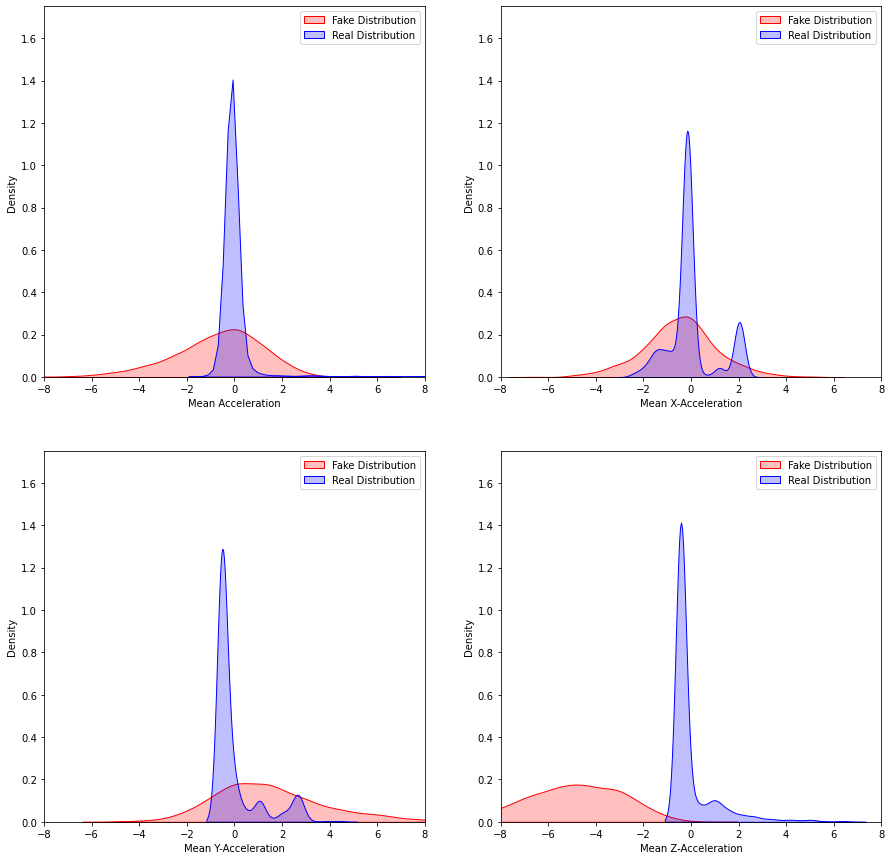

Starting Training: Conventional

Training Discriminator, Freezing Generator
Epoch[1/200] DISC | LossD: 0.6933, LossG: 0.7922 | Acc: 0.5002 | fpR: 0.0000 | R: 0.0004 | MedianW: 0.5249 | MeanW: 0.5091
Epoch[2/200] DISC | LossD: 0.6982, LossG: 0.7922 | Acc: 0.5002 | fpR: 0.0000 | R: 0.0004 | MedianW: 0.5242 | MeanW: 0.5088
Epoch[3/200] DISC | LossD: 0.6973, LossG: 0.7922 | Acc: 0.5002 | fpR: 0.0000 | R: 0.0004 | MedianW: 0.5257 | MeanW: 0.5089
Epoch[4/200] DISC | LossD: 0.6962, LossG: 0.7922 | Acc: 0.5002 | fpR: 0.0000 | R: 0.0004 | MedianW: 0.5251 | MeanW: 0.5087
Epoch[5/200] DISC | LossD: 0.6950, LossG: 0.7922 | Acc: 0.5009 | fpR: 0.0000 | R: 0.0018 | MedianW: 0.5251 | MeanW: 0.5090

Training Generator, Freezing Discriminator
Epoch[6/200] GEN | LossD: 0.6950, LossG: 0.7811 | Acc: 0.5009 | fpR: 0.0000 | R: 0.0018 | MedianW: 0.5232 | MeanW: 0.5124
Epoch[7/200] GEN | LossD: 0.6950, LossG: 0.7773 | Acc: 0.5009 | fpR: 0.0000 | R: 0.0018 | MedianW: 0.5284 | MeanW: 0.5102

Training Discriminat

Epoch[61/200] DISC | LossD: 0.4774, LossG: 0.5900 | Acc: 0.9878 | fpR: 0.0000 | R: 0.9756 | MedianW: 0.5255 | MeanW: 0.5378

Training Generator, Freezing Discriminator
Epoch[62/200] GEN | LossD: 0.4774, LossG: 0.8817 | Acc: 0.9851 | fpR: 0.0053 | R: 0.9756 | MedianW: 0.5633 | MeanW: 0.5482
Epoch[63/200] GEN | LossD: 0.4774, LossG: 0.7510 | Acc: 0.9498 | fpR: 0.0759 | R: 0.9756 | MedianW: 0.5978 | MeanW: 0.5593

Training Discriminator, Freezing Generator
Epoch[64/200] DISC | LossD: 0.4925, LossG: 0.7510 | Acc: 0.9578 | fpR: 0.0519 | R: 0.9676 | MedianW: 0.6022 | MeanW: 0.5615
Epoch[65/200] DISC | LossD: 0.4696, LossG: 0.7510 | Acc: 0.9718 | fpR: 0.0182 | R: 0.9618 | MedianW: 0.5985 | MeanW: 0.5596
Epoch[66/200] DISC | LossD: 0.4459, LossG: 0.7510 | Acc: 0.9729 | fpR: 0.0053 | R: 0.9512 | MedianW: 0.5986 | MeanW: 0.5594
Epoch[67/200] DISC | LossD: 0.4215, LossG: 0.7510 | Acc: 0.9698 | fpR: 0.0004 | R: 0.9401 | MedianW: 0.6005 | MeanW: 0.5608
Epoch[68/200] DISC | LossD: 0.4008, LossG: 0.7

Epoch[121/200] DISC | LossD: 0.3879, LossG: 1.6945 | Acc: 0.8979 | fpR: 0.0018 | R: 0.7976 | MedianW: 1.0184 | MeanW: 0.9926
Epoch[122/200] DISC | LossD: 0.3466, LossG: 1.6945 | Acc: 0.8992 | fpR: 0.0009 | R: 0.7994 | MedianW: 1.0091 | MeanW: 0.9976
Epoch[123/200] DISC | LossD: 0.3186, LossG: 1.6945 | Acc: 0.9032 | fpR: 0.0000 | R: 0.8065 | MedianW: 1.0578 | MeanW: 1.0262
Epoch[124/200] DISC | LossD: 0.3103, LossG: 1.6945 | Acc: 0.9103 | fpR: 0.0000 | R: 0.8207 | MedianW: 0.9953 | MeanW: 0.9810

Training Generator, Freezing Discriminator
Epoch[125/200] GEN | LossD: 0.3103, LossG: 1.8349 | Acc: 0.9090 | fpR: 0.0027 | R: 0.8207 | MedianW: 0.9577 | MeanW: 0.9486
Epoch[126/200] GEN | LossD: 0.3103, LossG: 1.7021 | Acc: 0.8793 | fpR: 0.0621 | R: 0.8207 | MedianW: 0.9254 | MeanW: 0.9429

Training Discriminator, Freezing Generator
Epoch[127/200] DISC | LossD: 0.4065, LossG: 1.7021 | Acc: 0.9032 | fpR: 0.0209 | R: 0.8273 | MedianW: 0.9271 | MeanW: 0.9405
Epoch[128/200] DISC | LossD: 0.3659, Lo

Epoch[181/200] GEN | LossD: 0.4152, LossG: 1.7004 | Acc: 0.8671 | fpR: 0.1660 | R: 0.9001 | MedianW: 0.8585 | MeanW: 0.9239
Epoch[182/200] GEN | LossD: 0.4152, LossG: 1.2360 | Acc: 0.7703 | fpR: 0.3595 | R: 0.9001 | MedianW: 0.8858 | MeanW: 0.9514

Training Discriminator, Freezing Generator
Epoch[183/200] DISC | LossD: 0.6176, LossG: 1.2360 | Acc: 0.8083 | fpR: 0.2810 | R: 0.8975 | MedianW: 0.8556 | MeanW: 0.9220
Epoch[184/200] DISC | LossD: 0.5544, LossG: 1.2360 | Acc: 0.8615 | fpR: 0.1749 | R: 0.8979 | MedianW: 0.8761 | MeanW: 0.9527
Epoch[185/200] DISC | LossD: 0.5389, LossG: 1.2360 | Acc: 0.8881 | fpR: 0.1176 | R: 0.8939 | MedianW: 0.8495 | MeanW: 0.9138
Epoch[186/200] DISC | LossD: 0.4695, LossG: 1.2360 | Acc: 0.9037 | fpR: 0.0852 | R: 0.8926 | MedianW: 0.8508 | MeanW: 0.9457
Epoch[187/200] DISC | LossD: 0.4286, LossG: 1.2360 | Acc: 0.9252 | fpR: 0.0413 | R: 0.8917 | MedianW: 0.8556 | MeanW: 0.9538

Training Generator, Freezing Discriminator
Epoch[188/200] GEN | LossD: 0.4286, Los

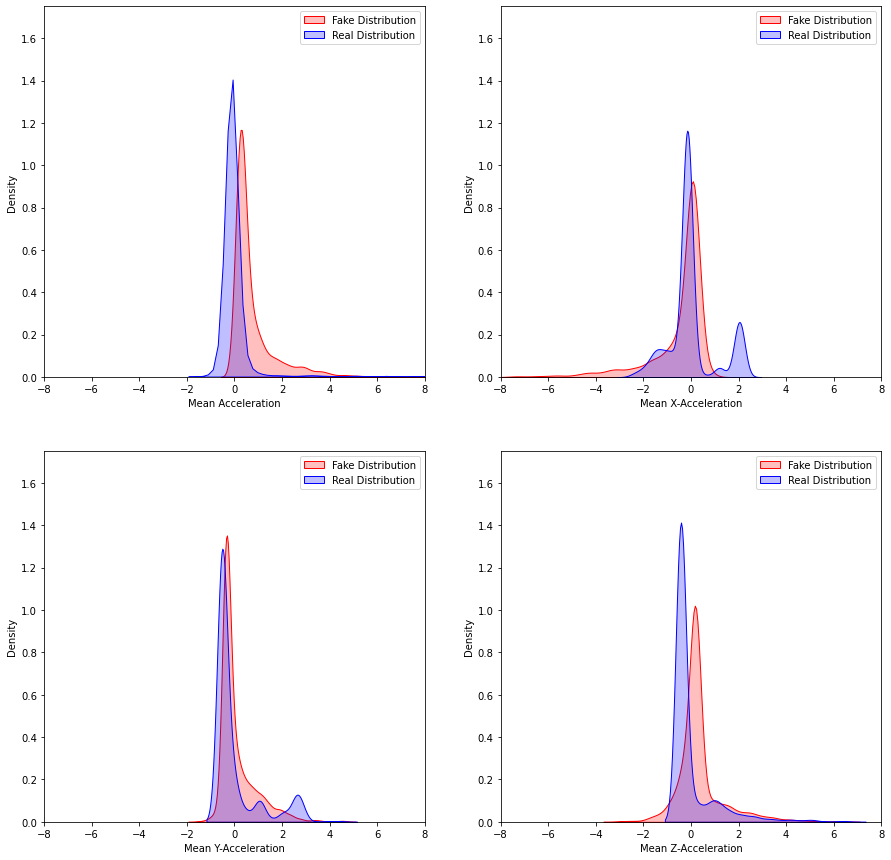

         7147010 function calls (7050648 primitive calls) in 75.311 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.120    0.120   75.311   75.311 <ipython-input-15-ba4e8e46c337>:52(training_loop)
        2    0.004    0.002   20.464   10.232 <ipython-input-13-37cd276fa1e2>:5(visualize_gen)
      200    0.040    0.000   18.872    0.094 <ipython-input-10-82116bfce3c9>:6(all_Wasserstein_dists)
      200    0.054    0.000   15.549    0.078 <ipython-input-10-82116bfce3c9>:12(<listcomp>)
     5200    0.081    0.000   15.495    0.003 C:\Users\jdeoliveira\anaconda3\lib\site-packages\scipy\stats\stats.py:7701(wasserstein_distance)
     5200    1.143    0.000   15.414    0.003 C:\Users\jdeoliveira\anaconda3\lib\site-packages\scipy\stats\stats.py:7861(_cdf_distance)
      400    0.014    0.000   15.350    0.038 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:513(__next__)
      400    

      200    0.005    0.000    0.915    0.005 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\autograd\grad_mode.py:24(decorate_context)
      200    0.034    0.000    0.900    0.005 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\optim\adam.py:55(step)
     2610    0.884    0.000    0.884    0.000 {method 'item' of 'torch._C._TensorBase' objects}
      592    0.008    0.000    0.828    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:268(_get_agg_font)
      200    0.209    0.001    0.822    0.004 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\optim\_functional.py:53(adam)
       16    0.005    0.000    0.784    0.049 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axes\_base.py:4095(get_tightbbox)
       48    0.003    0.000    0.766    0.016 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:1096(get_tightbbox)
       40    0.000    0.000    0.743    0.019 C:\Users\jdeoliveira\anaconda3\lib\s

     2412    0.163    0.000    0.163    0.000 {built-in method relu_}
   480810    0.161    0.000    0.161    0.000 {method 'append' of 'list' objects}
      112    0.004    0.000    0.159    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:341(_apply_params)
     4320    0.157    0.000    0.157    0.000 {method 'add_' of 'torch._C._TensorBase' objects}
       24    0.000    0.000    0.155    0.006 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\legend.py:899(get_tightbbox)
      200    0.001    0.000    0.154    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:1281(get_majorticklocs)
     6062    0.023    0.000    0.153    0.000 <__array_function__ internals>:2(concatenate)
80734/80574    0.069    0.000    0.149    0.000 {built-in method builtins.getattr}
       16    0.000    0.000    0.148    0.009 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:899(set_clip_path)
   189354    0.109    0.000    0.148  

      686    0.004    0.000    0.049    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:815(from_extents)
       96    0.002    0.000    0.049    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:770(cla)
      298    0.002    0.000    0.048    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:669(<listcomp>)
      384    0.003    0.000    0.048    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:2711(make_block)
      600    0.048    0.000    0.048    0.000 {built-in method mean}
     4877    0.016    0.000    0.048    0.000 C:\Users\jdeoliveira\anaconda3\lib\contextlib.py:117(__exit__)
     1324    0.004    0.000    0.048    0.000 <__array_function__ internals>:2(any)
       40    0.001    0.000    0.047    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:2094(_update_offset_text_position)
      800    0.006    0.000   

       32    0.000    0.000    0.033    0.001 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:10777(sum)
      144    0.001    0.000    0.033    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:502(__init__)
       32    0.000    0.000    0.032    0.001 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:10742(_min_count_stat_function)
       16    0.000    0.000    0.032    0.002 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:4159(_drop_axis)
      888    0.007    0.000    0.032    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:538(update_position)
    12358    0.027    0.000    0.032    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2254(_check_in_list)
      232    0.001    0.000    0.032    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotli

     2190    0.018    0.000    0.020    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:185(set_children)
     1520    0.020    0.000    0.020    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:2844(_interval_contains_close)
     1520    0.003    0.000    0.020    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:308(set_label2)
      220    0.001    0.000    0.020    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:1957(rotate_deg_around)
        8    0.000    0.000    0.020    0.003 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:2260(__init__)
       32    0.001    0.000    0.020    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\spines.py:31(__init__)
      448    0.001    0.000    0.020    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:2418(cumsum)
    31874    0.020    0.000

      776    0.001    0.000    0.015    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:41(_amin)
     1476    0.006    0.000    0.015    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\font_manager.py:832(set_style)
      128    0.004    0.000    0.015    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\ticker.py:2159(_validate_steps)
      200    0.015    0.000    0.015    0.000 {built-in method rsub}
     2304    0.004    0.000    0.015    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:2055(transform)
       80    0.001    0.000    0.015    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:3782(_get_item_cache)
       16    0.000    0.000    0.015    0.001 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:5544(insert)
      876    0.005    0.000    0.015    0.000 C:\Users\jdeoliv

     2705    0.006    0.000    0.011    0.000 C:\Users\jdeoliveira\anaconda3\lib\re.py:289(_compile)
      320    0.003    0.000    0.010    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:2666(__init__)
      494    0.010    0.000    0.010    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\lib\stride_tricks.py:183(_broadcast_shape)
      352    0.006    0.000    0.010    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:5408(__finalize__)
      656    0.003    0.000    0.010    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\units.py:58(_is_natively_supported)
      162    0.001    0.000    0.010    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\colors.py:281(to_rgba_array)
     1476    0.005    0.000    0.010    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\font_manager.py:842(set_variant)
      128    0.002    0.000    

  790/430    0.002    0.000    0.008    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axes\_base.py:700(get_xaxis_transform)
       64    0.001    0.000    0.008    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\dtypes\missing.py:367(array_equivalent)
      148    0.001    0.000    0.008    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\markers.py:753(_set_tickdown)
    21690    0.008    0.000    0.008    0.000 C:\Users\jdeoliveira\anaconda3\lib\inspect.py:2543(default)
     1104    0.005    0.000    0.008    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1268(is_math_text)
     1600    0.004    0.000    0.008    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\ticker.py:292(fix_minus)
      352    0.003    0.000    0.008    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\common.py:198(asarray_tuplesafe)
      380    0.0

        1    0.000    0.000    0.006    0.006 C:\Users\jdeoliveira\anaconda3\lib\site-packages\PIL\JpegImagePlugin.py:34(<module>)
1008/1006    0.002    0.000    0.006    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:2527(get_matrix)
     1344    0.006    0.000    0.006    0.000 {method 'size' of 'torch._C._TensorBase' objects}
     6540    0.006    0.000    0.006    0.000 {built-in method torch._C._has_torch_function_variadic}
      304    0.002    0.000    0.006    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:1912(clear)
      152    0.001    0.000    0.006    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\markers.py:739(_set_tickright)
     1144    0.003    0.000    0.006    0.000 C:\Users\jdeoliveira\anaconda3\lib\threading.py:1017(_wait_for_tstate_lock)
      176    0.005    0.000    0.006    0.000 {pandas._libs.lib.infer_dtype}
     1366    0.005    0.000    0.006    0.000 C:\Users\jdeoliveira

        6    0.000    0.000    0.004    0.001 <frozen importlib._bootstrap_external>:1302(_get_spec)
       32    0.001    0.000    0.004    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2123(update_datalim)
      128    0.001    0.000    0.004    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3197(_validate_converted_limits)
       64    0.001    0.000    0.004    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\algorithms.py:1534(_get_take_nd_function)
      126    0.000    0.000    0.004    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\patches.py:328(set_edgecolor)
        2    0.000    0.000    0.004    0.002 C:\Users\jdeoliveira\anaconda3\lib\site-packages\ipykernel\zmqshell.py:77(_flush_streams)
      112    0.001    0.000    0.004    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:3036(get_loc)
     2185  

      768    0.002    0.000    0.003    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\dtypes\base.py:199(construct_from_string)
       64    0.001    0.000    0.003    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\collections.py:791(_set_edgecolor)
        1    0.000    0.000    0.003    0.003 C:\Users\jdeoliveira\anaconda3\lib\site-packages\IPython\core\formatters.py:56(_default_formatter)
      192    0.002    0.000    0.003    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:425(_simple_new)
      428    0.001    0.000    0.003    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\text.py:1204(set_usetex)
       16    0.001    0.000    0.003    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\core\function_base.py:23(linspace)
       56    0.000    0.000    0.003    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotli

        2    0.000    0.000    0.002    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:164(draw_path_collection)
      510    0.002    0.000    0.002    0.000 {method 'astype' of 'numpy.ndarray' objects}
       16    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(in1d)
        2    0.001    0.001    0.002    0.001 {method 'draw_path_collection' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
       56    0.000    0.000    0.002    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:334(max)
      522    0.001    0.000    0.002    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\lines.py:531(set_markevery)
     1332    0.002    0.000    0.002    0.000 {built-in method torch._C.is_grad_enabled}
     10/2    0.000    0.000    0.002    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\traitlets\config\configurable.py:125(_find_my_config)
       64    0.000    0.000    

      576    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\lines.py:503(get_fillstyle)
      944    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\dtypes\common.py:195(<lambda>)
      690    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\core\_ufunc_config.py:429(__init__)
     1414    0.001    0.000    0.001    0.000 {built-in method builtins.vars}
        2    0.000    0.000    0.001    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\traitlets\traitlets.py:1592(traits)
       56    0.001    0.000    0.001    0.000 {built-in method matplotlib._path.count_bboxes_overlapping_bbox}
       32    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\collections.py:725(set_antialiased)
       12    0.000    0.000    0.001    0.000 {built-in method builtins.__build_class__}
    

        8    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\legend.py:1161(_parse_legend_args)
      208    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\offsetbox.py:729(get_extent)
      608    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:455(_get_axis_number)
       76    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\patches.py:757(get_path)
       64    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:763(limit_range_for_scale)
       80    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1674(sanitize_sequence)
      944    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\dtypes\common.py:190(

       16    0.001    0.000    0.001    0.000 {pandas._libs.algos.take_2d_axis0_float64_float64}
       64    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\dtypes\dtypes.py:870(construct_from_string)
      500    0.001    0.000    0.001    0.000 {built-in method math.cos}
        8    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\figure.py:2067(sca)
       32    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:946(intervaly)
      500    0.001    0.000    0.001    0.000 {built-in method math.sin}
       16    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\ticker.py:2308(view_limits)
      768    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\offsetbox.py:551(<genexpr>)
      379    0.000    0.000    0.001    0.000 C:\Users\jdeo

        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3463(get_ylim)
      704    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:247(flags)
      444    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\_jit_internal.py:833(is_scripting)
      768    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\offsetbox.py:552(<genexpr>)
       24    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:916(y0)
      520    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\colors.py:276(<genexpr>)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\optim\optimizer.py:232(add_param_group)
      352    0.000    0.000    0.000    0.000 C:

       34    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\colors.py:962(__init__)
       16    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\managers.py:1958(_preprocess_slice_or_indexer)
       16    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:2119(__init__)
       64    0.000    0.000    0.000    0.000 {method 'diagonal' of 'numpy.ndarray' objects}
       80    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:1359(get_major_locator)
       96    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\ma\core.py:3406(dtype)
      208    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\compat\numpy\function.py:45(__call__)
      288    0.000    

        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\ipykernel\iostream.py:209(send_multipart)
        4    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\nn\init.py:57(_no_grad_fill_)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\_pylab_helpers.py:111(_set_new_active_manager)
      288    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\markers.py:315(get_path)
       16    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\linalg\linalg.py:135(_commonType)
      160    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:1298(<listcomp>)
       16    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\managers.py:1863(_asarray_com

        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\cuda\__init__.py:279(get_device_capability)
       48    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\legend_handler.py:704(get_first)
       94    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\traitlets\traitlets.py:1130(cross_validation_lock)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\figure.py:163(__init__)
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\copy.py:258(_reconstruct)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\figure.py:488(set_constrained_layout)
      192    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\lib\stride_tricks.py:119(<genexpr>)
        2    0.000    0.000    0.0

        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\rcsetup.py:150(validate_bool)
      192    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\core\shape_base.py:78(_atleast_2d_dispatcher)
       32    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\lib\type_check.py:279(iscomplexobj)
       36    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\text.py:346(<listcomp>)
       32    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axes\_base.py:656(_request_autoscale_view)
       64    0.000    0.000    0.000    0.000 {pandas._libs.algos.ensure_platform_int}
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\gridspec.py:496(<dictcomp>)
       64    0.000    0.000    0.000    0.00

        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:285(buffer_rgba)
       32    0.000    0.000    0.000    0.000 {method 'conj' of 'numpy.ndarray' objects}
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\gridspec.py:622(__init__)
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\figure.py:91(_entry_from_axes)
       56    0.000    0.000    0.000    0.000 {built-in method time.perf_counter}
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\patches.py:1854(<dictcomp>)
        1    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:289(IFDRational)
       48    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\missing.py:64(clean

        4    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\IPython\lib\pretty.py:288(end_group)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\logging\__init__.py:1331(_fixupParents)
       16    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\seaborn\utils.py:671(_check_argument)
       10    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\traitlets\traitlets.py:118(isidentifier)
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2112(__init__)
       18    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:867(__exit__)
        6    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\_collections_abc.py:349(__subclasshook__)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\pyplot.py:755(get_fi

        1    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\copyreg.py:99(_slotnames)
       32    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\core\multiarray.py:468(can_cast)
       32    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:3304(_get_partial_string_timestamp_match_key)
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\figure.py:1059(fixitems)
        6    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:35(_new_module)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\__init__.py:1207(is_interactive)
        1    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:1665(AppendingTiffWriter)
        2    0.000    0.000    0.000    0.000 C:

        4    0.000    0.000    0.000    0.000 {method '__enter__' of '_thread.lock' objects}
        4    0.000    0.000    0.000    0.000 {built-in method _imp.lock_held}
       11    0.000    0.000    0.000    0.000 {built-in method torch._C._cuda_getDeviceCount}
        4    0.000    0.000    0.000    0.000 {method 'is_complex' of 'torch._C._TensorBase' objects}
        4    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\contextlib.py:697(__init__)
        1    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:307(multiprocessing_context)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\IPython\core\displaypub.py:43(_validate_data)
        6    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\_pylab_helpers.py:34(get_fig_ma

In [16]:
#Load Data
model_output = None
print("Loading Data")
X, y = start_data("sample_data.csv", "label:SITTING")

#Set to true to see conventional training, false for dynamic training
conventional = True

#Profile runtime of GAN training
with cProfile.Profile() as pr:
    #Train
    training_loop(X,y, gan_id="gan_demo", batch_size = len(X), gen_lr=.005, disc_lr =.005, n_epochs=200, dig=4, constant_train_flag=conventional, disc_epochs = 5, gen_epochs = 2, save_models = False)
pr = pstats.Stats(pr).sort_stats('cumtime')
pr.print_stats()